In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from joblib import dump

# Setting up nltk
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SURIYA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SURIYA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Reading the data
df = pd.read_csv('random_dataset.csv')

# Exploring the data
print(df.head())


                              COMMENT_ID        AUTHOR                 DATE  \
0      z12pgdhovmrktzm3i23es5d5junftft3f   lekanaVEVO1  2014-07-22T15:27:50   
1    z13yx345uxepetggz04ci5rjcxeohzlrtf4      Pyunghee  2014-07-27T01:57:16   
2  z12lsjvi3wa5x1vwh04cibeaqnzrevxajw00k    Erica Ross  2014-07-27T02:51:43   
3    z13jcjuovxbwfr0ge04cev2ipsjdfdurwck  Aviel Haimov  2014-08-01T12:27:48   
4  z13qybua2yfydzxzj04cgfpqdt2syfx53ms0k    John Bello  2014-08-01T21:04:03   

                                             CONTENT  CLASS  
0  i love this so much. AND also I Generate Free ...      1  
1  http://www.billboard.com/articles/columns/pop-...      1  
2  Hey guys! Please join me in my fight to help a...      1  
3  http://psnboss.com/?ref=2tGgp3pV6L this is the...      1  
4  Hey everyone. Watch this trailer!!!!!!!!  http...      1  


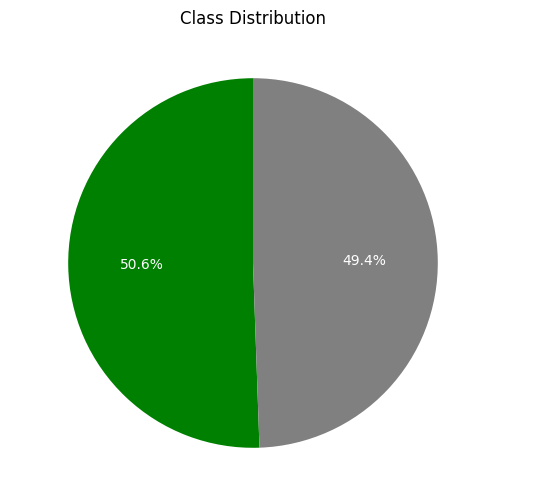

In [19]:
# Adding a class label column
df['class_label'] = df['CLASS'].map({1: 'Spam', 0: 'Not Spam'})

# Visualizing class distribution
class_counts = df['class_label'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90, colors=['green', 'grey'], textprops= { 'color': 'white' })
plt.title('Class Distribution')
plt.show()


In [20]:
# Preprocessing comments
comments = df['CONTENT'].apply(lambda x: x.lower())
print(comments)
labels = df['CLASS'].values
comments = comments.apply(lambda x: re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 'http', str(x)))
comments = comments.apply(lambda x: x.replace('\ufeff', ''))
comments_token = comments.apply(lambda x: x.split())


0       i love this so much. and also i generate free ...
1       http://www.billboard.com/articles/columns/pop-...
2       hey guys! please join me in my fight to help a...
3       http://psnboss.com/?ref=2tggp3pv6l this is the...
4       hey everyone. watch this trailer!!!!!!!!  http...
                              ...                        
2952         i enjoyed watching this. limited time offer!
2953    you're doing a great job! share this with some...
2954    you've earned a new subscriber! follow me on s...
2955    unlock premium content! spam tag a friend who ...
2956                               wtf what the fu** dude
Name: CONTENT, Length: 2957, dtype: object


### preprocessing the contents
 * comments are converted to lowercase
 * The regular expression is used to remove the URL of a website which is not useful for current text classification.
 * Removed ufe encoding as it is appears randomly

In [21]:
# Removing stopwords
stop_words = set(stopwords.words('english')) 
comments_rsw = [[w for w in comment_token if not w in stop_words] for comment_token in comments_token]


Example of stopwords - `is` `the` `and` `of` `in`

In [22]:
# Lemmatizing words
lemma = nltk.WordNetLemmatizer()
comments_lemma = [[lemma.lemmatize(w) for w in comment] for comment in comments_rsw]


Lemmatizing words example - `running`, `runs`, and `ran` is `run`

In [23]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(comments_lemma, labels, test_size=0.8, shuffle=True, random_state=0, stratify=labels)


In [24]:
# Creating bag of words
X_train_untokenized = [' '.join(comment) for comment in X_train]
X_test_untokenized = [' '.join(comment) for comment in X_test]
vect = CountVectorizer(min_df=3)
vect.fit(X_train_untokenized)
X_train = vect.transform(X_train_untokenized).toarray()
X_test = vect.transform(X_test_untokenized).toarray()


CountVector - Feature extraction technique converting data into numerical representation

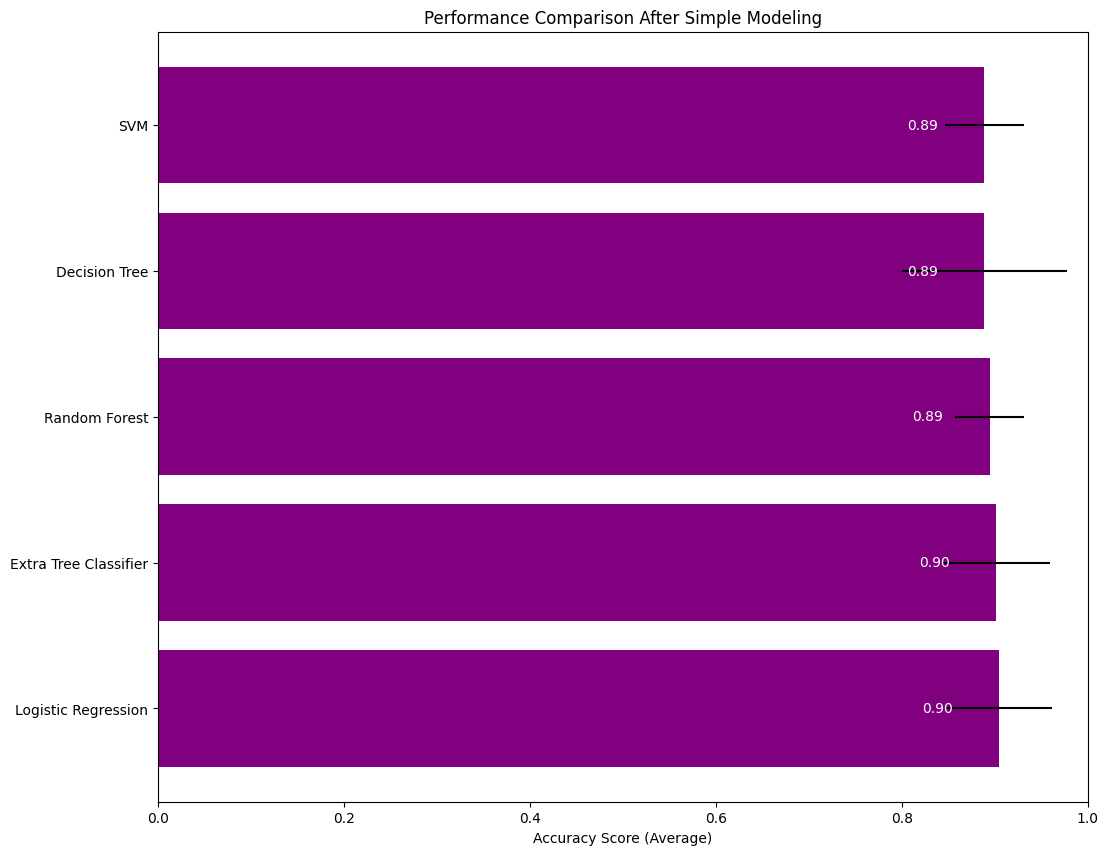

In [26]:
# Model evaluation
estimators = [
    ('Decision Tree', DecisionTreeClassifier),
    ('Logistic Regression', LogisticRegression),
    ('Random Forest', RandomForestClassifier),
    ('SVM', SVC),
    ('Extra Tree Classifier', ExtraTreesClassifier)
]
comparison_cols = ['Algorithm', 'Training Time (Avg)', 'Accuracy (Avg)', 'Accuracy (3xSTD)']
comparison_df = pd.DataFrame(columns=comparison_cols)
cv_split = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
for idx, (name, estimator) in enumerate(estimators):
    cv_results = cross_validate(estimator(), X_train, y_train, cv=cv_split)
    comparison_df.loc[idx, 'Algorithm'] = name
    comparison_df.loc[idx, 'Training Time (Avg)'] = cv_results['fit_time'].mean()
    comparison_df.loc[idx, 'Accuracy (Avg)'] = cv_results['test_score'].mean()
    comparison_df.loc[idx, 'Accuracy (3xSTD)'] = cv_results['test_score'].std() * 3

comparison_df.set_index(keys='Algorithm', inplace=True)
comparison_df.sort_values(by='Accuracy (Avg)', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(12, 10))
y_pos = np.arange(len(comparison_df))
bars = ax.barh(y_pos, comparison_df['Accuracy (Avg)'], xerr=comparison_df['Accuracy (3xSTD)'], color='purple')
ax.set_yticks(y_pos)
ax.set_yticklabels(comparison_df.index)
ax.set_xlabel('Accuracy Score (Average)')
ax.set_title('Performance Comparison After Simple Modeling')
ax.set_xlim(0, 1)

# Annotate each bar with its corresponding value
for bar, acc in zip(bars, comparison_df['Accuracy (Avg)']):
    ax.text(bar.get_width() - 0.05, bar.get_y() + bar.get_height()/2, f'{acc:.2f}', va='center', ha='right', color='white')

plt.show()


`cross_validate` - evaulvates estimator preformance using cross validation

`StratifiedShuffleSplit` - Type of Stratergy used for cross validation. shuffles the data before splitting, maintains randomness and reproducibility

In [29]:
# Training and evaluating the best model
best_model_name = comparison_df.index[0]

# Map model names to their corresponding class names in scikit-learn
model_name_mapping = {
    'Decision Tree': 'DecisionTreeClassifier',
    'Logistic Regression': 'LogisticRegression',
    'Random Forest': 'RandomForestClassifier',
    'SVM': 'SVC',
    'Extra Tree Classifier': 'ExtraTreesClassifier'
}


In [30]:
# Retrieve the corresponding class name
if best_model_name in model_name_mapping:
    best_model_class = model_name_mapping[best_model_name]
    best_model = globals()[best_model_class]()  # Instantiate the class
    best_model.fit(X_train, y_train)
    predictions = best_model.predict(X_test)
    print('The accuracy of the best model on the test set:', accuracy_score(y_test, predictions))
else:
    print("Error: Model name not found in mapping")


The accuracy of the best model on the test set: 0.9027895181741336


In [31]:
# Saving the best model
dump((best_model, vect), 'best_model.pkl')


['best_model.pkl']

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      1170
           1       0.92      0.84      0.88      1196

    accuracy                           0.88      2366
   macro avg       0.89      0.88      0.88      2366
weighted avg       0.89      0.88      0.88      2366



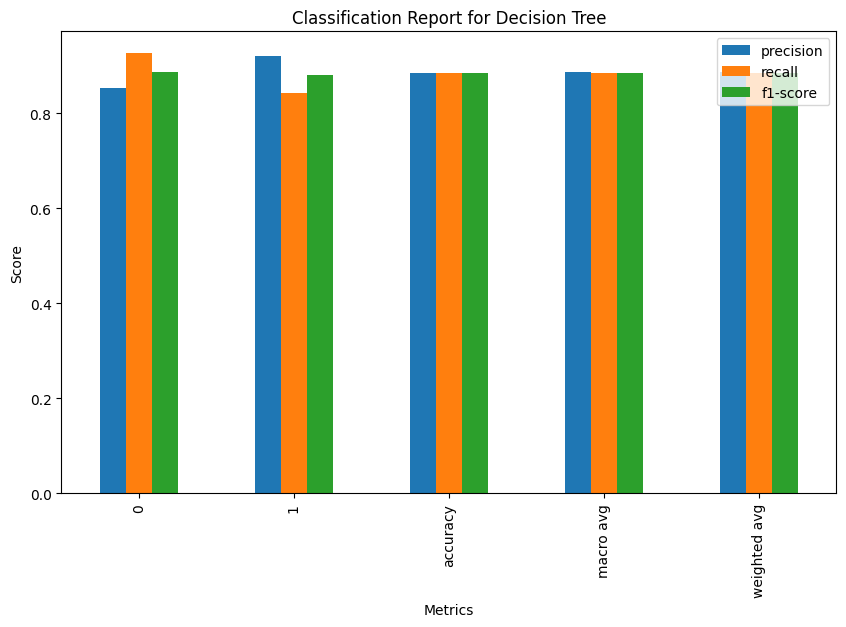

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      1170
           1       0.97      0.83      0.90      1196

    accuracy                           0.90      2366
   macro avg       0.91      0.90      0.90      2366
weighted avg       0.91      0.90      0.90      2366



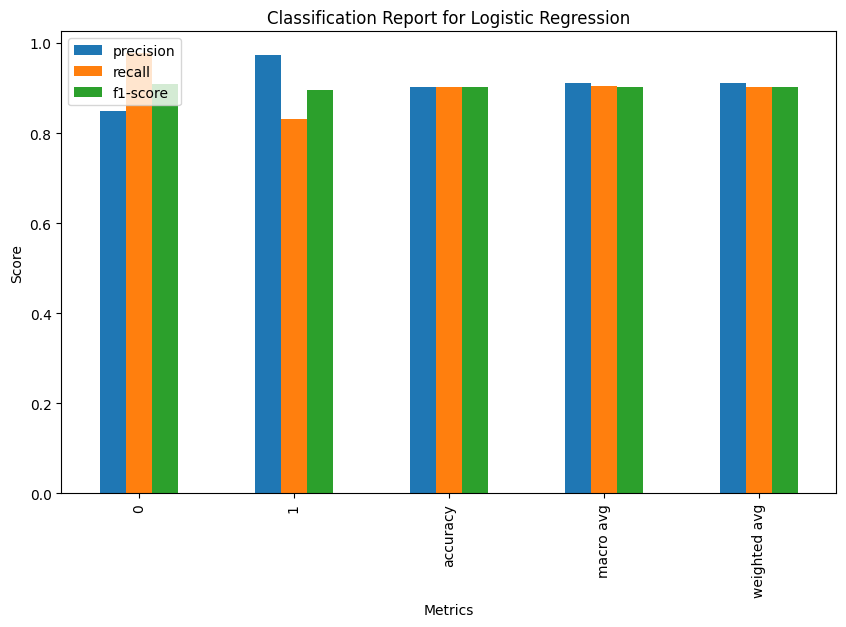

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      1170
           1       0.94      0.85      0.89      1196

    accuracy                           0.90      2366
   macro avg       0.90      0.90      0.90      2366
weighted avg       0.90      0.90      0.90      2366



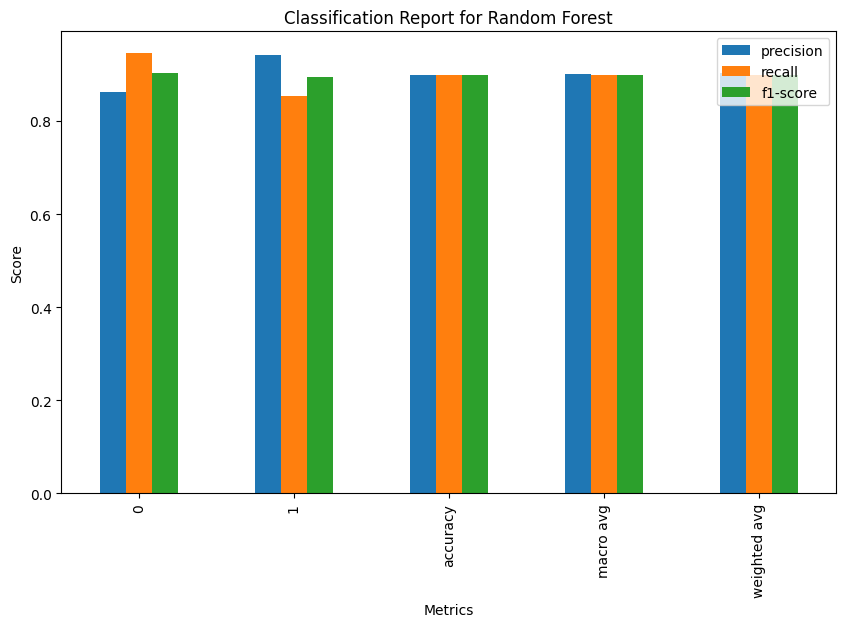

Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.84      0.94      0.88      1170
           1       0.93      0.82      0.87      1196

    accuracy                           0.88      2366
   macro avg       0.88      0.88      0.88      2366
weighted avg       0.88      0.88      0.88      2366



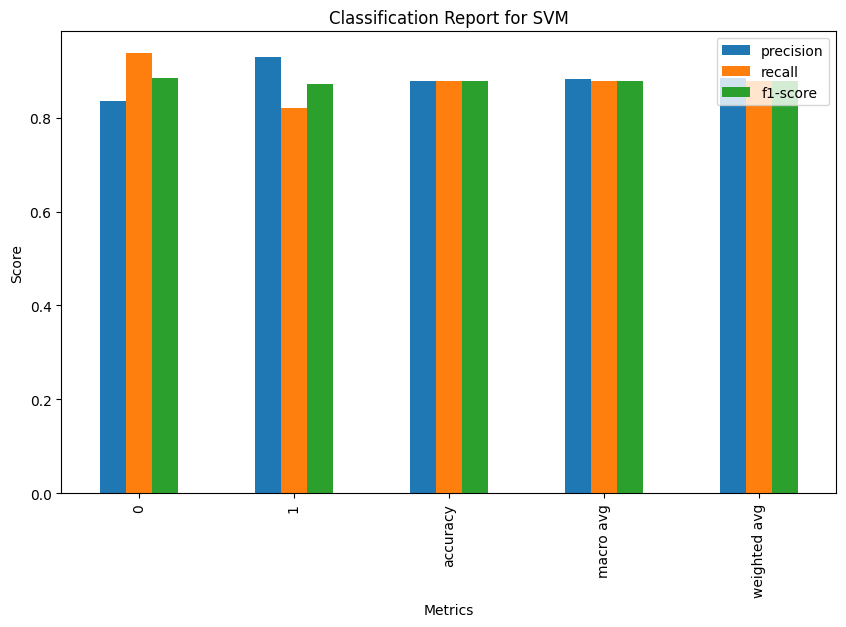

Classification Report for Extra Tree Classifier:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1170
           1       0.95      0.88      0.92      1196

    accuracy                           0.92      2366
   macro avg       0.92      0.92      0.92      2366
weighted avg       0.92      0.92      0.92      2366



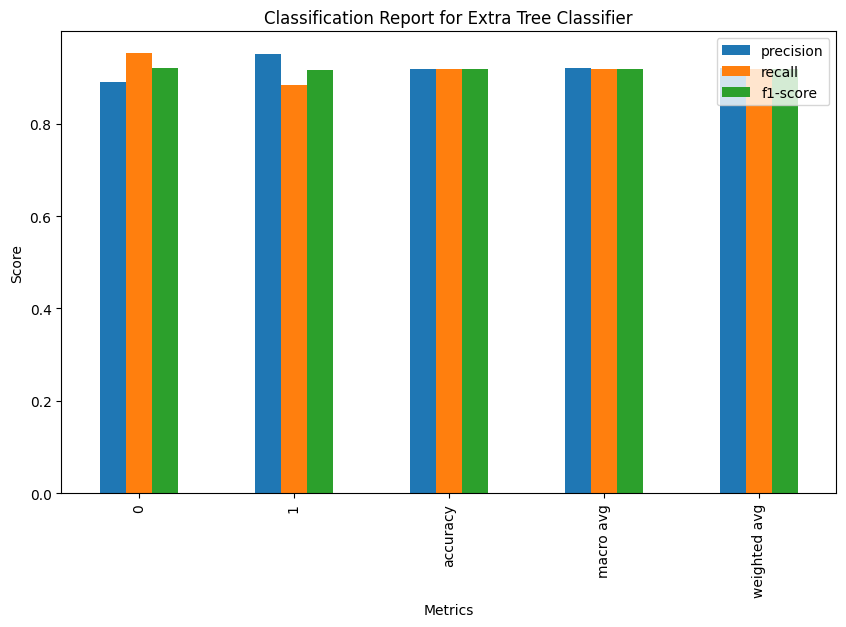

In [32]:
# Generating and displaying classification reports
# Training and evaluating all models
for idx, (name, estimator) in enumerate(estimators):
    clf = estimator()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    report = classification_report(y_test, y_pred)
    print(f"Classification Report for {name}:")
    print(report)

    # Generating and displaying classification report plot
    fig, ax = plt.subplots(figsize=(10, 6))
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    df_report = pd.DataFrame(report_dict).transpose()
    df_report.drop(columns=['support'], inplace=True)
    df_report.plot(kind='bar', ax=ax)
    ax.set_title(f'Classification Report for {name}')
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Score')
    plt.show()
